# Instalando bibliotecas

In [3]:
""" Installing libraries """
%pip install pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0 torch==2.8.0

Note: you may need to restart the kernel to use updated packages.


# Importando bibliotecas (externas e próprias)

In [4]:
""" Importing libraries """

import sys
import os

# Add the parent directory to sys.path so 'Modules' can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Our modules
from Modules.loading.read_parquet import read_parquet_file 
from Modules.preprocessing.onehot import one_hot_encode_parquet
from Modules.models.make_dataset import SingleSeriesDataset, MultiSeriesDataset
from Modules.models.NBeats import NBeatsBlock, NBeats
from Modules.models.WMAPELoss import WMAPELoss
from Modules.models.training import train_model
from Modules.models.test import soft_test
from Modules.models.test import hard_test

ImportError: cannot import name 'hard_test1' from 'Modules.models.test' (c:\Users\range\OneDrive\Área de Trabalho\Mestrado\Projetinhos\hackathon-big_data_tech\Files\Code\Modules\models\test.py)

# Definição dos hiper-parâmetros

In [ ]:
""" Defining hyper-parameters """
# Neural Network Global Parameters
input_size = 30  # Number of past days to use as input
output_size = 7  # Number of future days to predict
batch_size = 28  # Batch size for training

n_layers = 4  # Number of layers in the N-BEATS model
hidden_size = 128  # Number of hidden units in each layer

# Training parameters
learning_rate = 1e-3 # Learning rate for the optimizer
epochs = 1000  # Number of training epochs (iterations over the entire dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
blind_horizon = 4  # Number of days to exclude from the end of the training set for hard test

# Importação do Dataset

É interessante dividir o treino em batches (mini-conjuntos de treino). Cada batch possui o tamanho de input size, seguindo a ordem cronológica de vendas dentro daquela janela de dias. No entanto, durante o treinamento é **ESSENCIAL** que a escolha do próximo batch seja aleatória.

Ex.: Inicia o treino por 21-27 jul e prevê 28, depois pula para 02-08 fev para prever 03. Esse processo deve ser repetido até todos os dados serem treinados, finalizando **01 epoch**.

O número de **epochs** diz o número total de iterações do modelo com relação ao dataset inteiro.

Sobre a composição da janela de input dentro de um batch, existem duas abordagens:

1) Treinar em cada janela todas as séries (pense que cada par produto-loja x tempo representa uma série temporal dentro daquele período). Esse modelo é bem mais complexo pois o output deve ter o mesmo tamanho de produto-loja.
2) Treinar vários modelos separados (considerando uma série temporal para cada modelo). Esse método é ineficiente pois o modelo nunca irá aprender os padrões entre as séries.
3) Treinar o modelo com um par produto-loja por vez. Ou seja:
   - O modelo realiza epochs = N iterações de treino ao longo de todo dataset
     - Em cada epoch, passa por todas as M batches
       - Em cada batch (que possui uma janela de tamanho input_size), atualiza os parâmetros para cada série temporal ($x_l,y_l$). Totalizando L atualizações, com L sendo o número de pares produto-loja.

Ressalta-se que cada conjunto ($x_l,y_l$) representa:
- $x_l$: série temporal do l-ésimo par produto-loja, sendo um vetor de tamanho input_size x (features + 1)
- $y_l$: Previsão de vendas do l-ésimo par produto-loja para os próximos $output_size$ dias


In [ ]:
""" Setting up the constants """

DATA_PATH = "../Data/hackathon_2025_templates/part-00000-tid-"

FILE_HASH = [
    "2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36",
    "5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8",
    "7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1",
]

SUFIX = "-4-1-c000.snappy.parquet"

FILE_NAMES = [DATA_PATH + hash + SUFIX for hash in FILE_HASH]

In [ ]:
""" Loading the data """

pdv_data = read_parquet_file(FILE_NAMES[0])
transaction_data = read_parquet_file(FILE_NAMES[1])
product_data = read_parquet_file(FILE_NAMES[2])

In [ ]:
pdv_data.head()

,pdv,premise,categoria_pdv,zipcode
0,2204965430669363375,On Premise,Mexican Rest,30741
1,5211957289528622910,On Premise,Hotel/Motel,80011
2,9024493554530757353,Off Premise,Convenience,80751
3,8659197371382902429,On Premise,Restaurant,80439
4,1400854873763881130,On Premise,Restaurant,30093


In [ ]:
transaction_data.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758


In [ ]:
product_data.head()

,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc


# Reorganizando os dados em pares produto-loja

In [ ]:

# 1) juntar produto
df = transaction_data.merge(
    product_data,
    left_on="internal_product_id",
    right_on="produto",
    how="left"
)

# 2) juntar loja
df = df.merge(
    pdv_data,
    left_on="internal_store_id",
    right_on="pdv",
    how="left"
)

# 3) garantir que a data esteja no formato datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# 4) pivotar: dia x par produto-loja
full_df = (
    df.pivot_table(
        index="transaction_date",                        # agora usa transaction_date
        columns=["internal_product_id", "internal_store_id"],  
        values="quantity",                               # mantenha 'quantity' se esse for o nome certo
        aggfunc="sum",
        fill_value=0
    )
)

# 5) deixar colunas mais legíveis: produto_loja
full_df.columns = [f"{p}_{l}" for p, l in full_df.columns]

# 6) garantir todas as datas do período (mesmo sem vendas)
full_df = full_df.reindex(
    pd.date_range(df["transaction_date"].min(), df["transaction_date"].max(), freq="D"),
    fill_value=0
)
full_df.index.name = "data"

full_df[:] = full_df[:].astype(int)

print(f"A tabela de pares de produto-loja tem shape: {full_df.shape}")

A tabela de pares de produto-loja tem shape: (365, 1044310)


# Teste univariado aleatório

<BarContainer object of 365 artists>

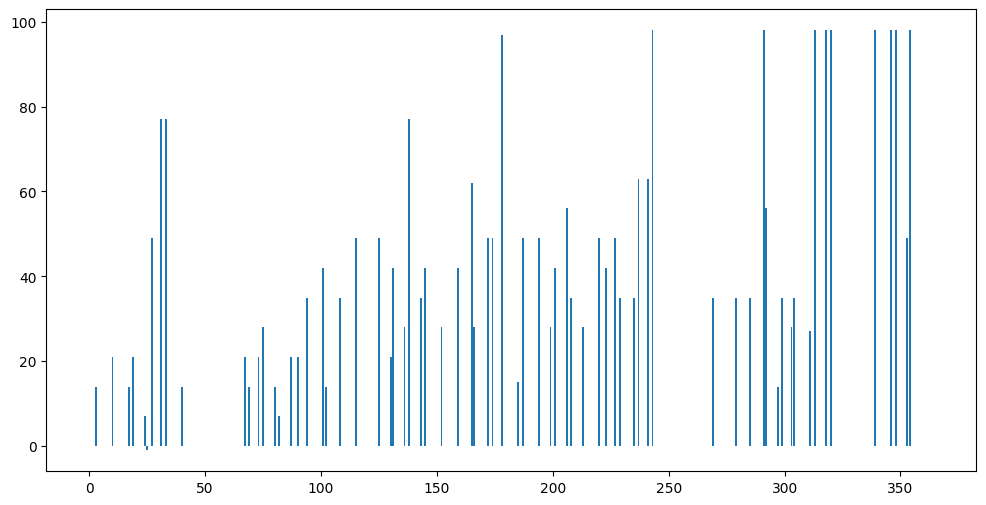

In [ ]:
sum_df = full_df.sum().sort_values(ascending=True)

test_sample = full_df[sum_df.index[-450]].values
plt.figure(figsize=(12, 6))
plt.bar(range(len(full_df)), test_sample)


# Transformando o Dataframe em um Dataset



In [ ]:
# Admissão de um sample para teste univariado
sample = test_sample

# Criação de um feature básico, de diferença entre dados consecutivos 
feature_1 = [sample[t] - sample[t-1] for t in range(1, len(sample))]

# Normalização dos dados para a faixa [0, 1] - MÉTODO SIMPLES, PESQUISAR OUTROS
sample = (test_sample - np.min(test_sample)) / (np.max(test_sample) - np.min(test_sample))
feature_1 = (feature_1 - np.min(feature_1)) / (np.max(feature_1) - np.min(feature_1))



In [ ]:
# Inicializando os vetores de entrada e os rótulos
X = []
y = []

# Número total de amostras (janelas diferentes) que podem ser extraídas
# de um mesmo sample
num_windows = len(sample) - input_size - output_size + 1
print(f"Número total de janelas extraídas: {num_windows}")
print(f"Para janelas de tamanho {input_size} e previsão de {output_size} dias à frente.")
# Extraindo janelas deslizantes
for i in range(num_windows):

    X_window = sample[i:i+input_size]             # janela de entrada
    feature_1_window = feature_1[i:i+input_size]      # janela de entrada

    X_window = np.stack([X_window,feature_1_window], axis=1)  # shape = (input_size, 4)

    y_window = sample[i+input_size:i+input_size+output_size]  # próximos dias da série

    X.append(X_window)
    y.append(y_window)

# Convertendo para arrays numpy e depois para tensores PyTorch
X = np.array(X)  # shape = [num_windows, input_size, num_features]
y = np.array(y)  # shape = [num_windows, output_size]
print()
print("O vetor de entrada  antes do flatten")
print(f"tem shape (num_windows, size_window, num_features): {X.shape}")

X = torch.tensor(X, dtype=torch.float32)  # shape = [n_samples, input_size, 1]

y = torch.tensor(y, dtype=torch.float32)  # shape = [n_samples, 1]


dataset_full = SingleSeriesDataset(X, y)


Número total de janelas extraídas: 329
Para janelas de tamanho 30 e previsão de 7 dias à frente.

O vetor de entrada  antes do flatten
tem shape (num_windows, size_window, num_features): (329, 30, 2)


# Separando os dados entre treino / validação

Os dados serão separados na proporção 80% - treino / 20% validação. Para séries temporais, é usual que essa separação seja feita de forma cronológica

In [ ]:
# Ponto de separação entre treino e validação
split_point = int(0.8 * len(dataset_full))

# Separação cronológica das janelas
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

num_features = X_train.shape[2]

# Flatten do tensor para entrar na rede
X_train = X_train.view(X_train.shape[0], -1)  # shape = [num_windows_train, input_size * n_features]
X_test  = X_test.view(X_test.shape[0], -1) # shape = [num_windows_test, input_size * n_features]

print(f"Há um total de {len(dataset_full)} janelas e o split_point = {split_point}, em 80%")
print(f" O shape de X_train é {X_train.shape} e o shape de X_test é {X_test.shape}")
print(f" O shape de y_train é {y_train.shape} e o shape de y_test é {y_test.shape}")

Há um total de 329 janelas e o split_point = 263, em 80%
 O shape de X_train é torch.Size([263, 60]) e o shape de X_test é torch.Size([66, 60])
 O shape de y_train é torch.Size([263, 7]) e o shape de y_test é torch.Size([66, 7])


# Treinamento

In [ ]:
# Adotando o dataset de treino
dataset = SingleSeriesDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

# Inicialização do modelo N-BEATS (considerando X_train com num_features)
model = NBeats(input_size * num_features, hidden_size, output_size, n_layers).to(device)

model, criterion, optimizer = train_model(model, learning_rate, epochs, device, dataloader)




Epoch 1/1000, Loss: 1.3377
Epoch 2/1000, Loss: 1.0328
Epoch 3/1000, Loss: 0.9608
Epoch 4/1000, Loss: 0.9473
Epoch 5/1000, Loss: 0.9053
Epoch 6/1000, Loss: 0.9075
Epoch 7/1000, Loss: 0.9001
Epoch 8/1000, Loss: 0.9071
Epoch 9/1000, Loss: 0.9035
Epoch 10/1000, Loss: 0.8972
Epoch 11/1000, Loss: 0.8960
Epoch 12/1000, Loss: 0.9050
Epoch 13/1000, Loss: 0.9034
Epoch 14/1000, Loss: 0.9065
Epoch 15/1000, Loss: 0.9018
Epoch 16/1000, Loss: 0.8931
Epoch 17/1000, Loss: 0.8959
Epoch 18/1000, Loss: 0.8922
Epoch 19/1000, Loss: 0.8793
Epoch 20/1000, Loss: 0.8860
Epoch 21/1000, Loss: 0.8885
Epoch 22/1000, Loss: 0.8887
Epoch 23/1000, Loss: 0.8885
Epoch 24/1000, Loss: 0.8936
Epoch 25/1000, Loss: 0.8915
Epoch 26/1000, Loss: 0.8941
Epoch 27/1000, Loss: 0.8840
Epoch 28/1000, Loss: 0.8828
Epoch 29/1000, Loss: 0.8770
Epoch 30/1000, Loss: 0.8766
Epoch 31/1000, Loss: 0.8732
Epoch 32/1000, Loss: 0.8709
Epoch 33/1000, Loss: 0.8726
Epoch 34/1000, Loss: 0.8769
Epoch 35/1000, Loss: 0.8842
Epoch 36/1000, Loss: 0.8874
E

# Sanity check do modelo treinado

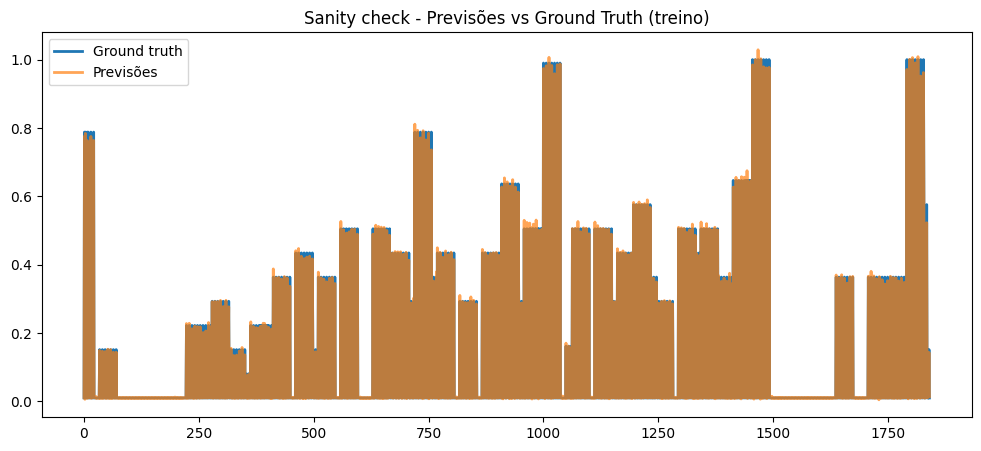

In [ ]:
def sanity_check_plot(model, dataloader, device, output_size):
    """
    Plota previsões vs ground truth no período de treino
    """
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            preds = model(x)
            
            # Se seu modelo retorna (batch, output_size)
            preds = preds.cpu().numpy().flatten()
            y = y.cpu().numpy().flatten()

            all_preds.extend(preds)
            all_targets.extend(y)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(all_targets, label="Ground truth", linewidth=2)
    plt.plot(all_preds, label="Previsões", linewidth=2, alpha=0.7)
    plt.title("Sanity check - Previsões vs Ground Truth (treino)")
    plt.legend()
    plt.show()

sanity_check_plot(model, dataloader, device, output_size)

In [ ]:
y

tensor([[0.0101, 0.7879, 0.0101,  ..., 0.0101, 0.0101, 0.0101],
        [0.7879, 0.0101, 0.7879,  ..., 0.0101, 0.0101, 0.0101],
        [0.0101, 0.7879, 0.0101,  ..., 0.0101, 0.0101, 0.0101],
        ...,
        [0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101],
        [0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101],
        [0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101]])

# Validação do modelo

São feitos dois testes:

- **Soft test:** Modelo  tenta fazer as previsões, mas não utiliza-as nas previsões futuras, utiliza sempre os *ground truth* como input
- **Hard test:** Modelo tenta fazer as previsões, e utiliza $y_{i-1}$ para a previsão de $y_i$

In [ ]:
all_preds_S, all_targets_S, avg_loss_test_S = soft_test(model, dataloader, device, criterion)

model.eval()
total_loss = 0
all_preds = []
all_targets = []
forecast = []


X_test_blind = X_train[split_point - 1]

# Rótulo correspondente ao último ponto de entrada do conjunto de teste
y_test_blind = y_train[split_point - 1]


for i in range(blind_horizon):

    # Enviando para o dispositivo (GPU/CPU)
    X_test_blind = X_test_blind.to(device)
    # y_test_blind = y_test_blind.to(device)
    
    # Fazendo a previsão do modelo
    forecast = model(X_test_blind)

    # Atualizando a entrada para a próxima previsão (autoregressivo)
    X_test_blind = torch.cat((X_test_blind[output_size:], forecast), dim=0)
    y_test_blind = y_test[(i+1)*output_size - 1]

    # Armazenando previsões e rótulos
    all_preds.append(forecast.cpu())
    all_targets.append(y_test_blind.cpu())
    
    loss = criterion(forecast, y_test_blind)
    total_loss += loss.item()

avg_loss = total_loss / blind_horizon
print(f"Average Loss - Hard Test: {avg_loss:.4f}")

Average Loss - Soft Test: 0.0300
Average Loss - Hard Test: 1.1437


Apesar da diferença grande entre os erros do **Hard Test** e **Soft Test**, ressalta-se que, ao adicionar features exógenas aos dados não previstos (dia da semana, do mês, mês) essas features auxiliam na estabilidade do input, mesmo que o próprio modelo continue fornecendo informações imperfeitas

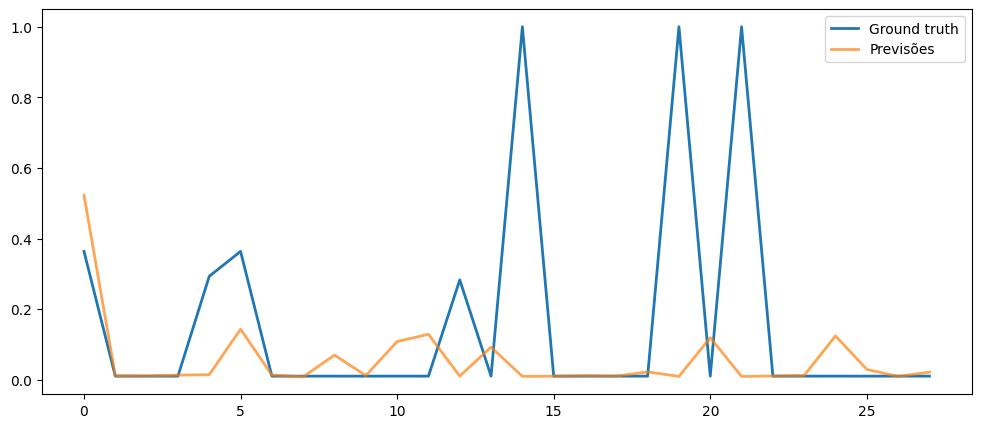

In [ ]:
" Sanity check da validação do modelo (preds and targets)"
all_preds_array = []
all_targets_array = []

import torch

# Convert lists to tensors before flattening
all_preds_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_preds], dim=0).flatten()
all_targets_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_targets], dim=0).flatten()

for t in all_preds_tensor:
    all_preds_array.append(t.detach().numpy())
for t in all_targets_tensor:
    all_targets_array.append(t.detach().numpy())


plt.figure(figsize=(12, 5))
plt.plot(all_targets_array, label="Ground truth", linewidth=2)
plt.plot(all_preds_array, label="Previsões", linewidth=2, alpha=0.7)
plt.legend()

# Ponto de parada - RAB 18-09-25

Nosso modelo está acertando bem nos dados de treino e de teste fácil, mas (não se sabe se) ele performa mal no treino difícil, pois o erro se acumula rápido. Isso é um indicativo de:
- Se quisermos mandar bem em dados desconhecidos completamente, precisaremos de muitas features auxiliares
- O dataset de exemplo é bem comportado. Queremos então séries bem comportadas (mesmo que sejam ruidosas, mas presentes) para nossa rede. Valores de outliers podem ser:
  - Descartados
  - Previstos probabilisticamente
  - De forma trivial, falar que, para todos os outliers de jan-22, se repetirá em jan-23

No entanto, para isso precisamos entender melhor os dados, o que eu sugiro:
1) Pegar a tabelona de produto-loja e tentar filtrar aquelas que são relevantes
2) Pegar, para cada loja, os k-ésimos (1, 3, 5) produtos mais vendidos ao longo do ano, ou mais frequentes, e visualizar esses sinais
3) Ver, no geral, quais produtos são mais populares dentre todo dataset

Após fazermos essas análises, teremos uma boa ideia de que parte do nosso dataset será boa para inputar a caixa preta. Após essa escolha, pensamos nas features:
- Temporais (mais fáceis de pensar e implementar)
- Categóricas (intrínsecas do produto ou da loja, como a categoria deles)
- De localização (apenas se der tempo)

Após termos feito isso, podemos então realizar normalização dos sinais, one hot encoding do que for viável e embedding de IDs etc